In [2]:
"""
Code to generate autoregressive data.

Source: https://github.com/jessicayung/blog-code-snippets/blob/master/generate-ar-data/generate_data.py
Blog post: http://www.jessicayung.com/generating-autoregressive-data-for-experiments=

Author: Jessiac Yung
Sept 2018
"""
import numpy as np
from sklearn.model_selection import train_test_split

class TimeSeriesData:
    def __init__(self, num_datapoints, test_size=0.2, max_t=20, num_prev=1,
                 noise_var=1):
        """
        Template class for generating time series data.
        :param test_size: in (0,1), data to be used in test set as a fraction of all data generated.
        """
        self.num_datapoints = num_datapoints
        self.test_size = test_size
        self.num_prev = num_prev
        self.max_t = max_t
        self.data = None
        self.noise_var = noise_var
        self.y = np.zeros(num_datapoints + num_prev*4) # TODO: check this
        self.bayes_preds = np.copy(self.y)

        # Generate data and reshape data
        self.create_data()

        # Split into training and test sets
        self.train_test_split()

    def create_data(self):
        self.generate_data()
        self.reshape_data()

    def generate_data(self):
        """Generates data in self.y, may take as implicit input timesteps self.t.
        May also generate Bayes predictions."""
        raise NotImplementedError("Generate data method not implemented.")

    def reshape_data(self):
        self.x = np.reshape([self.y[i:i + self.num_prev] for i in range(
            self.num_datapoints)], (-1, self.num_prev))
        self.y = np.copy(self.y[self.num_prev:])
        self.bayes_preds = np.copy(self.bayes_preds[self.num_prev:])

    def train_test_split(self):
        test_size = int(len(self.y) * self.test_size)
        self.data = [self.X_train, self.X_test, self.y_train,
                     self.y_test] = \
                    self.x[:-test_size], self.x[-test_size:], \
                    self.y[:-test_size], self.y[-test_size:]
        self.bayes_preds = [self.bayes_train_preds, self.bayes_test_preds] = self.bayes_preds[:-test_size], self.bayes_preds[-test_size:]

    def return_data(self):
        return self.data

    def return_train_test(self):
        return self.X_train, self.y_train, self.X_test, self.y_test

class ARData(TimeSeriesData):
    """Class to generate autoregressive data."""

    def __init__(self, *args, coeffs=None, **kwargs):
        self.given_coeffs = coeffs
        super(ARData, self).__init__(*args, **kwargs)

        if coeffs is not None:
            self.num_prev = len(coeffs) - 1

    def generate_data(self):
        self.generate_coefficients()
        self.generate_initial_points()

        # + 3*self.num_prev because we want to cut first (3*self.num_prev) datapoints later
        # so dist is more stationary (else initial num_prev datapoints will stand out as diff dist)
        for i in range(self.num_datapoints+3*self.num_prev):
            # Generate y value if there was no noise
            # (equivalent to Bayes predictions: predictions from oracle that knows true parameters (coefficients))
            self.bayes_preds[i + self.num_prev] = np.dot(self.y[i:self.num_prev+i][::-1], self.coeffs)
            # Add noise
            self.y[i + self.num_prev] = self.bayes_preds[i + self.num_prev] + self.noise()

        # Cut first 20 points so dist is roughly stationary
        self.bayes_preds = self.bayes_preds[3*self.num_prev:]
        self.y = self.y[3*self.num_prev:]

    def generate_coefficients(self):
        if self.given_coeffs is not None:
            self.coeffs = self.given_coeffs
        else:
            filter_stable = False
            # Keep generating coefficients until we come across a set of coefficients
            # that correspond to stable poles
            while not filter_stable:
                true_theta = np.random.random(self.num_prev) - 0.5
                coefficients = np.append(1, -true_theta)
                # check if magnitude of all poles is less than one
                if np.max(np.abs(np.roots(coefficients))) < 1:
                    filter_stable = True
            self.coeffs = true_theta

    def generate_initial_points(self):
        # Initial datapoints distributed as N(0,1)
        self.y[:self.num_prev] = np.random.randn(self.num_prev)

    def noise(self):
        # Noise distributed as N(0, self.noise_var)
        return self.noise_var * np.random.randn()

# A set of coefficients that are stable (to produce replicable plots, experiments)
fixed_ar_coefficients = {2: [ 0.46152873, -0.29890739],
    5: [ 0.02519834, -0.24396899,  0.2785921,   0.14682383,  0.39390468],
                        10: [-0.10958935, -0.34564819,  0.3682048,   0.3134046,  -0.21553732,  0.34613629,
  0.41916508,  0.0165352,   0.14163503, -0.38844378],
                         20: [ 0.1937815,   0.01201026,  0.00464018, -0.21887467, -0.20113385, -0.02322278,
  0.34285319, -0.21069086,  0.06604683, -0.22377364,  0.11714593, -0.07122126,
 -0.16346554,  0.03174824,  0.308584,    0.06881604,  0.24840789, -0.32735569,
  0.21939492, 0.3996207 ]}

"""
Example of using fixed coefficients (consistency across tests of different models)

data = ARData(100, coeffs=fixed_ar_coefficients[5], num_prev=5)
plt.plot(data.y_train)
"""


'\nExample of using fixed coefficients (consistency across tests of different models)\n\ndata = ARData(100, coeffs=fixed_ar_coefficients[5], num_prev=5)\nplt.plot(data.y_train)\n'

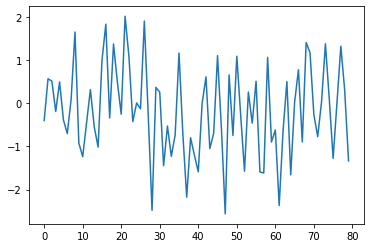

In [5]:
import matplotlib.pyplot as plt
data = ARData(100, coeffs=fixed_ar_coefficients[5], num_prev=5)
plt.plot(data.y_train)